# **RelPose++ Demo**

This notebook is a demonstration of RelPose++.

Project Webpage: https://amyxlase.github.io/relpose-plus-plus/

**Data**: Please take 2-8 turntable images of an object, minimizing background clutter. You can upload these images to Colab using the upload interface. Example images are provided if you prefer not to take your own.

In [2]:
!nvidia-smi

Sat Dec 30 17:00:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           Off| 00000000:01:00.0 Off |                    0 |
| N/A   37C    P0               61W / 300W|      0MiB / 81920MiB |     21%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
# # Download code & model weights, unzip, and install dependencies
# %%capture
# !git clone --depth 1 https://github.com/amyxlase/relpose-plus-plus.git
# !pip install -r /content/relpose-plus-plus/requirements.txt
# !gdown https://drive.google.com/uc?id=1FGwMqgLXv4R0xMzEKVv3n3Aghn0MQXKY&export=download
# !unzip relposepp_weights.zip

In [4]:
# # Install Pytorch3d
# %%capture
# import os
# import sys
# import torch

# # We try to install PyTorch3D via a released wheel.
# pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
# version_str="".join([
#     f"py3{sys.version_info.minor}_cu",
#     torch.version.cuda.replace(".",""),
#     f"_pyt{pyt_version_str}"
# ])
# !pip install fvcore iopath
# !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

# # If the above fails to install Pytorch3D, uncomment the lines below to try to installing from source.
# # !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
# # !tar xzf 1.10.0.tar.gz
# # os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
# # !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [6]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
from PIL import Image

import sys
sys.path.insert(0, "relpose")

from pytorch3d.renderer import FoVPerspectiveCameras
from pytorch3d.vis.plotly_vis import plot_scene

from dataset import CustomDataset
from eval import evaluate_coordinate_ascent, evaluate_mst
from models import get_model
from utils import unnormalize_image, view_color_coded_images_from_path, view_color_coded_images_from_tensor

In [7]:
# Load pretrained weights
model, args = get_model(
    model_dir="relposepp_masked/",
    num_images=8,
    device="cuda"
)

Loading checkpoint ckpt_000800000.pth
Missing keys: ['feature_extractor.feature_positional_encoding.pos_table_1']
Unexpected keys: []


(800, 600, 3)
(800, 600, 3)
(800, 600, 3)
(800, 600, 3)
(800, 600, 3)
(800, 600, 3)
(800, 600, 3)
(800, 600, 3)


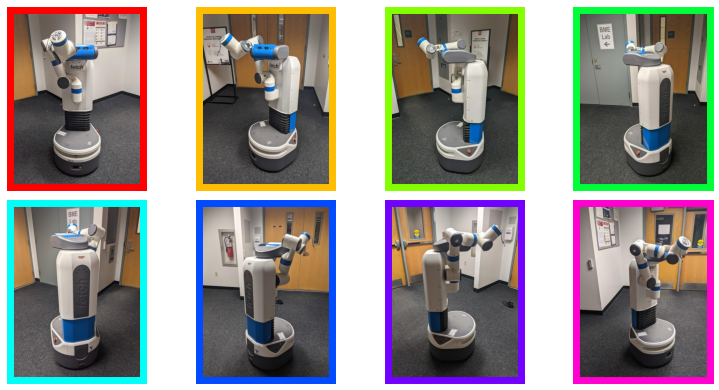

In [8]:
# TODO: Replace the path below to a directory with your own images.
# NOTE: The interactive tool used later in this demo may be slow if your images are >1MB.
# Alternatively, several examples can be found in this examples directory.

# Example directories may have weird files in them that need to be removed
# But the code will be updated soon
IMAGE_DIR = "examples/robot/images"

# Visualize initial images
fig, num_frames = view_color_coded_images_from_path(IMAGE_DIR)

In [9]:
#@title Interactive Bounding Box Selection Application

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from PIL import Image
import plotly.express as px
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash
import cv2
import numpy as np
from plotly.subplots import make_subplots


app = JupyterDash(__name__)

def process_list(l):

    if len(l) < num_frames:
      status = f"Bounding box selected for {len(l)} out of {num_frames} images.\n"
    else:
      status = "All bounding boxes have been selected.\n"

    return status + str(l)

class select_bbox():

  def __init__(self, image_dir, downscale_factor):

    # Pick max 8 well formed paths
    hidden = lambda x: not x.startswith(".")
    image_paths = sorted(os.listdir(image_dir))
    image_paths = list(filter(hidden, image_paths))
    image_paths = image_paths[0:(min(len(image_paths), 8))]

    self.num_frames = len(image_paths)
    self.s = 1 / downscale_factor

    num_rows = 1 if num_frames < 5 else 2
    fig = make_subplots(
          rows=num_rows,
          cols=4,
    )

    for i in range(self.num_frames):

      # Load image and resize
      img = Image.open(osp.join(IMAGE_DIR, image_paths[i]))
      new_shape = (int(self.s * img.width), int(self.s * img.height))
      img = img.resize(new_shape)

      # Add to figure
      r, c = (i // 4 + 1), (i % 4 + 1)
      fig.add_trace(go.Image(z=img, hoverinfo="none"), r, c)

      fig.update_layout(
          {ax:{"visible":False, "matches":None} for ax in fig.to_dict()["layout"] if "axis" in ax},
          autosize=False,
          width=1000,
          height=400,
          dragmode='drawrect',
          newshape=dict(line_color='cyan'),
      )

    config = {
      "modeBarButtonsToAdd": [
          "eraseshape",
      ]
    }

    app.layout = html.Div(
        [
            dcc.Graph(id="middle-sai", figure=fig, config=config),
            html.Pre(id="bbox-data",style={"color": "white"}),
        ]
    )

    self.callbacks(app)

  def callbacks(self, app):
    @app.callback(
        Output("bbox-data", "children"),
        Input("middle-sai", "relayoutData"),
        prevent_initial_call=True,
    )
    def on_new_annotation(relayout_data):

        if "shapes" in relayout_data:
            master_dict = {}

            for i in range(len(relayout_data["shapes"])):
                key = relayout_data["shapes"][i]['xref']
                x0 = int(relayout_data["shapes"][i]['x0'])
                y0 = int(relayout_data["shapes"][i]['y0'])
                x1 = int(relayout_data["shapes"][i]['x1'])
                y1 = int(relayout_data["shapes"][i]['y1'])
                master_dict[key] = [x0, y0, x1, y1]

            l = [master_dict[k] for k in sorted(master_dict.keys())]
            return html.Div([html.Div(process_list(l))],style={"color": "cyan"})

        else:
            return dash.no_update

  def show_image(self):
      app.run_server(debug=False,mode='inline')

/work/ececis_research/peace/sw/anaconda-envs/svd3d/20231214/lib/python3.10/site-packages/dash/dash.py:538: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



In [10]:
# TODO: For each image, please select a bounding box using the interactive tool below.
# The tool should take less than a minute to load.
# If it is taking longer, try increasing the downscale factor below or creating a new runtime.
# Information about drawn bounding boxes will appear below the display.
# If you would like to redo a bounding box, select it and press 'Erase Active Shape' in the top right.

DOWNSCALE_FACTOR = 10
s = select_bbox(IMAGE_DIR, DOWNSCALE_FACTOR)
s.show_image()

In [11]:
# TODO: Replace the list below with the bboxes from the output above.
bboxes = [[10, 4, 46, 79], [7, 7, 51, 75], [13, 7, 49, 77], [18, 11, 47, 77], [11, 6, 47, 79], [16, 11, 50, 75], [13, 6, 51, 70], [20, 10, 51, 76]]

bboxes = [[bboxes[i][j] * DOWNSCALE_FACTOR for j in range(4)] for i in range(num_frames)]

/work/ececis_research/peace/sw/anaconda-envs/svd3d/20231214/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



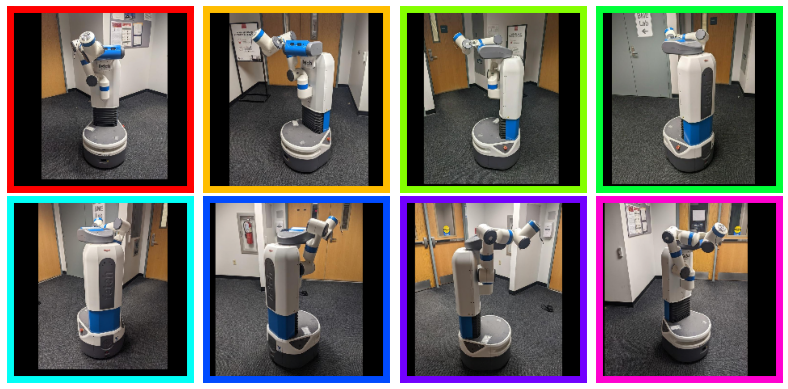

In [12]:
# Load in the wild images and crop parameters
dataset = CustomDataset(
    image_dir=IMAGE_DIR,
    bboxes=bboxes
)
num_frames = dataset.n
batch = dataset.get_data(ids=np.arange(num_frames))
images = batch["image"].to("cuda:0")
crop_params = batch["crop_params"].to("cuda:0")

# Visualize cropped and resized images
view_color_coded_images_from_tensor(images)

In [15]:
#@title Plotly Scene Visualization Setup

def plotly_scene_visualization(R_pred, T_pred, name):
  # Construct cameras and visualize scene for quick solution
  cameras_pred = FoVPerspectiveCameras(R=R_pred, T=T_pred)
  scenes = {name: {}}

  for i in range(num_frames):
      scenes[name][i] = FoVPerspectiveCameras(R=R_pred[i, None], T=T_pred[i, None])

  fig = plot_scene(
      scenes,
      camera_scale=0.03,
      ncols=2,
  )
  fig.update_scenes(aspectmode="data")

  cmap = plt.get_cmap("hsv")
  for i in range(num_frames):
      fig.data[i].line.color = matplotlib.colors.to_hex(cmap(i / (num_frames)))

  fig.show()

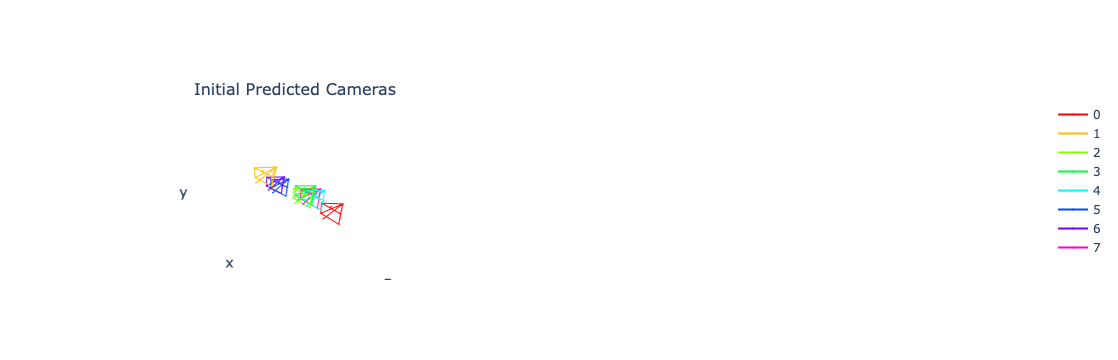

Iteratively finetuning the initial MST solution.


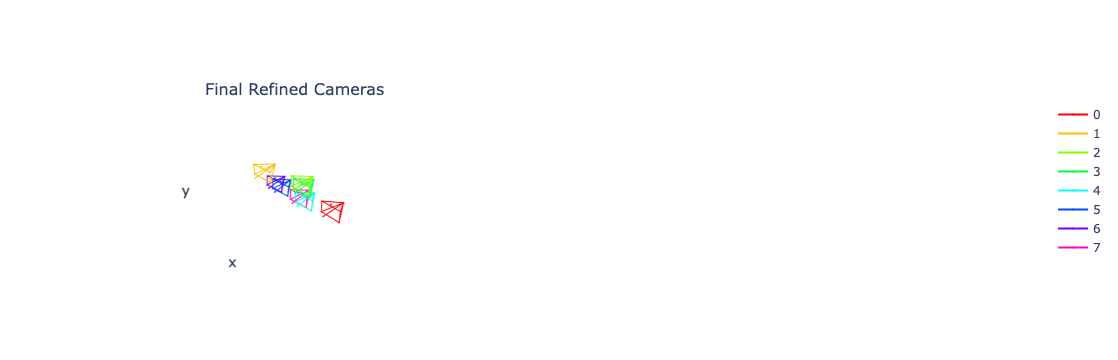

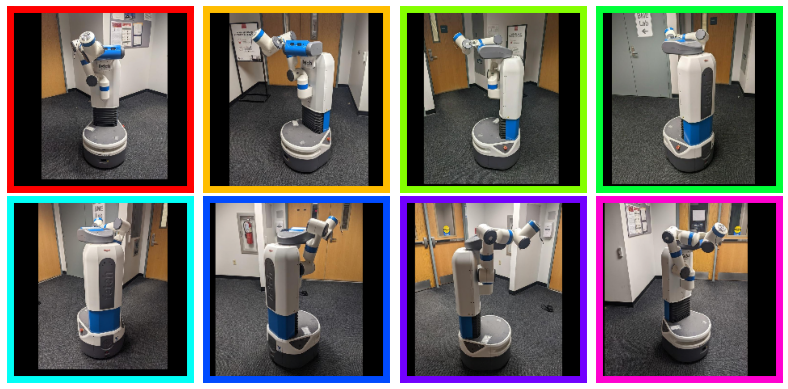

In [16]:
# Quickly initialize a coarse set of poses using MST reasoning
batched_images, batched_crop_params = images.unsqueeze(0), crop_params.unsqueeze(0)

_, hypothesis = evaluate_mst(
    model=model,
    images=batched_images,
    crop_params=batched_crop_params,
)
R_pred = np.stack(hypothesis)


# Regress to optimal translation
with torch.no_grad():
    _, _, T_pred = model(
        images=batched_images,
        crop_params=batched_crop_params,
    )

# Construct cameras and visualize scene for quick solution
plotly_scene_visualization(R_pred, T_pred, "Initial Predicted Cameras")

# Search for optimal rotation via coordinate ascent.
# This should take less than 30 seconds.
print("Iteratively finetuning the initial MST solution.")
_, hypothesis = evaluate_coordinate_ascent(
    model=model,
    images=batched_images,
    crop_params=batched_crop_params,
)
R_final = np.stack(hypothesis)

# Construct cameras and visualize scene for best solution
plotly_scene_visualization(R_final, T_pred, "Final Refined Cameras")

# Visualize cropped and resized images
view_color_coded_images_from_tensor(images)

In [17]:
!python relpose/demo.py  --image_dir examples/robot/images \
    --mask_dir examples/robot/masks --output_path robot.html

Traceback (most recent call last):
  File "/work/ececis_research/peace/dino-diffusion/relpose-plus-plus/relpose/demo.py", line 152, in <module>
    main(**vars(args))
  File "/work/ececis_research/peace/dino-diffusion/relpose-plus-plus/relpose/demo.py", line 87, in main
    model, args = get_model(model_dir, device=device, num_images=8)
  File "/work/ececis_research/peace/dino-diffusion/relpose-plus-plus/relpose/models/util.py", line 18, in get_model
    last_checkpoint = sorted(os.listdir(checkpoint_dir))[-1]
FileNotFoundError: [Errno 2] No such file or directory: 'weights/relposepp/checkpoints'
